# FF25 vs market: spread Sharpe with PSR/MinTRL/DSR
Does these portfolios deliver a higher Sharpe than just holding the market?

Idea: turn each FF_i vs the market into the Sharpe of the long-short spread, then test that single Sharpe with PSR, MinTRL, and DSR.

## TL;DR

- Only SMALL HiBM clearly beats the market once we apply DSR at 99% confidence.
- Around 11 other spreads look good on single-spread PSR but fail once we guard against multiple testing.
- Most spreads have modest edge, so MinTRL says we would need much longer samples to make a 99% call on them.

## Roadmap

- Build the long–short return $d_{i,t} = r_{i,t} - r_{M,t}$ (long FF_i, short market).
- For each spread, test whether its Sharpe is above 0 using PSR and check if we have enough history via MinTRL.
- Control for trying 25 spreads at once with DSR: use the correlation matrix to get an effective number of trials and shift the null Sharpe up before retesting each spread.

In [1]:
from pathlib import Path
import sys

sys.path.insert(0, str(Path('..')))
sys.path.insert(0, str(Path('..') / 'src'))

import numpy as np
import pandas as pd

from finance_data import metrics
from finance_data.datasets import ensure_french_datasets
from finance_data.french import load_us_research_factors_wide
from finance_data.spreads import compute_spread_stats

pd.set_option('display.float_format', lambda v: f"{v:0.6f}")

DATA_DIR = Path('../data')
START = '1926-07-01'
ALPHA = 0.05


## Data

Fama-French 25 value-weighted monthly excess returns (1926-07 onward) and the market excess return (Mkt-RF). All stats stay at monthly frequency (no annualization).

In [2]:
datasets = ensure_french_datasets(output_dir=DATA_DIR, start=START, refresh=False)

ff25_excess = datasets['excess_25'].copy()
ff25_excess.index = pd.to_datetime(ff25_excess.index).to_period('M').to_timestamp('M')

ff_factors, rf_series = load_us_research_factors_wide(start_date=START)
ff_factors.index = pd.to_datetime(ff_factors.index).to_period('M').to_timestamp('M')
factors = ff_factors.join(rf_series, how='inner')

common_dates = ff25_excess.index.intersection(factors.index)
ff25_excess = ff25_excess.loc[common_dates]
factors = factors.loc[common_dates]

market_excess = factors['Mkt-RF']
rf = factors['RF']

spread_rel = ff25_excess.sub(market_excess, axis=0)
num_obs = spread_rel.shape[0]
num_ports = spread_rel.shape[1]

print(f"Aligned FF25 vs market sample: {num_obs} months ({common_dates.min().date()} to {common_dates.max().date()})")
print(f"Portfolios: {num_ports} long-short spreads (FF_i minus market)")

Aligned FF25 vs market sample: 1191 months (1926-07-31 to 2025-09-30)
Portfolios: 25 long-short spreads (FF_i minus market)


## 1. What we test (FF_i − Market)

For each portfolio i we use the trade $FF_i - Market$:

- $d_{i,t} = r_{i,t} - r_{M,t}$
- $SR_{rel_i} = \mu_d / \sigma_d$

This is a single-portfolio Sharpe, so the PSR/DSR tools apply directly without any joint-law complications.

In [3]:
effective_trials = metrics.effective_num_tests(spread_rel)
# fallback to raw K if the correlation-based estimate is not finite
m_eff = effective_trials if np.isfinite(effective_trials) else spread_rel.shape[1]

spread_stats = compute_spread_stats(
    spread_rel,
    alpha=ALPHA,
    m_eff=m_eff,
    periods_per_year=12,
)
spread_stats.head()

,n_obs,mu_d,sigma_d,sr_rel,skew,kurt,psr_z,psr,psr_pass,min_trl_obs,...,enough_history,sr_rel_mean_all,sr_rel_var_all,m_eff_used,sr0_dsr_global,sr0_dsr,sigma_sr0,dsr,dsr_pass,verdict
portfolio,,,,,,,,,,,,,,,,,,,,,
SMALL HiBM,1191,0.006478,0.059372,0.109110,4.643733,49.290756,3.765498,0.999917,True,227.259203,...,True,0.048958,0.001898,3.747328,0.043957,0.043957,0.026226,0.993509,True,Trust: spread beats market with >=95% DSR afte...
ME2 BM5,1191,0.005360,0.050569,0.106000,2.492723,23.692390,3.658159,0.999873,True,240.791540,...,True,0.048958,0.001898,3.747328,0.043957,0.043957,0.027511,0.987941,True,Trust: spread beats market with >=95% DSR afte...
ME3 BM4,1191,0.003061,0.031768,0.096355,2.873667,33.211157,3.325278,0.999558,True,291.413935,...,True,0.048958,0.001898,3.747328,0.043957,0.043957,0.027325,0.972418,True,Trust: spread beats market with >=95% DSR afte...
ME4 BM4,1191,0.002737,0.030101,0.090924,2.196633,27.069970,3.137879,0.999149,True,327.260710,...,True,0.048958,0.001898,3.747328,0.043957,0.043957,0.027733,0.954823,True,Trust: spread beats market with >=95% DSR afte...
ME3 BM5,1191,0.004135,0.046462,0.089002,2.620564,28.259815,3.071523,0.998935,True,341.553568,...,True,0.048958,0.001898,3.747328,0.043957,0.043957,0.027458,0.949544,False,PSR passes at 95% but not after multiple-test ...


## 2. How strong each spread looks alone

We test $H_0: SR_{rel} \leq 0$ vs $H_1: SR_{rel} > 0$. At $SR_0 = 0$ the Sharpe estimator has variance $1/T$, so a simple approximation is

- $z_i = SR_{rel_i} \sqrt{T}$
- $PSR_i = \Phi(z_i)$
- $MinTRL_i = (z_{1-\alpha} / SR_{rel_i})^2$ observations (infinite if $SR_{rel_i} \leq 0$)

This gives a one-sided $(1-\alpha)$ decision per spread **before** any multiple-testing guard (here $\alpha = 0.01$).

In [4]:
num_trials = spread_rel.shape[1]
print(f"Number of spreads (K): {num_trials}")
print(f"Effective trials from return correlations (participation ratio): {effective_trials:.2f}")
print(f"m_eff fed into DSR: {m_eff:.2f}")

Number of spreads (K): 25
Effective trials from return correlations (participation ratio): 3.75
m_eff fed into DSR: 3.75


## 3. Guarding against lucky winners (DSR)

With $K = 25$ spreads we expect some lucky highs under the null $SR \leq 0$. The Deflated Sharpe Ratio (DSR) shifts the null Sharpe **upwards** based on:

- the cross-spread Sharpe variance (how much the Sharpe ratios vary across spreads), and
- the effective number of trials $K_{eff}$ from the spread correlation matrix (participation ratio).

For each spread we then evaluate the Sharpe variance at this higher $SR_0^{DSR}$ using its own skew/kurtosis and compute $DSR_i = \Phi\big((SR_i - SR_0^{DSR})/\sigma_{SR0}\big)$. The next cell reports $K$, $K_{eff}$, cross-spread Sharpe moments, and the resulting $SR_0^{DSR}$.

In [5]:
sr_mean = spread_stats['sr_rel_mean_all'].iloc[0] if 'sr_rel_mean_all' in spread_stats else float(spread_stats['sr_rel'].mean())
sr_var = spread_stats['sr_rel_var_all'].iloc[0] if 'sr_rel_var_all' in spread_stats else float(spread_stats['sr_rel'].var(ddof=1))
if 'sr0_dsr_global' in spread_stats:
    sr0_dsr = float(spread_stats['sr0_dsr_global'].iloc[0])
else:
    from finance_data.spreads import _dsr_null_from_spreads
    dsr_null = _dsr_null_from_spreads(spread_stats['sr_rel'], m_eff)
    sr0_dsr = float(dsr_null['sr0_dsr']) if dsr_null['sr0_dsr'] is not None else float('nan')

print(f"Cross-spread SR mean: {sr_mean:.4f}")
print(f"Cross-spread SR variance: {sr_var:.6f}")
print(f"DSR SR0 from False Strategy Theorem (K_eff = {m_eff:.2f}): {sr0_dsr:.4f}")


Cross-spread SR mean: 0.0490
Cross-spread SR variance: 0.001898
DSR SR0 from False Strategy Theorem (K_eff = 3.75): 0.0440


## 4. Who really beats the market?

Decision rule (one-sided, $\alpha = 0.05$):

1. If $T < MinTRL_i$: data is too short to make a 95% call.
2. Else if $DSR_i \geq 1 - \alpha$: trust that the spread beats the market **after** multiple-test deflation.
3. Else if $PSR_i \geq 1 - \alpha$: passes the single-spread PSR but not the multiple-testing guard.
4. Otherwise: no robust outperformance vs the market at 95%.

In [6]:
cols = [
    'sr_rel',
    'n_obs',
    'psr',
    'psr_pass',
    'min_trl_years',
    'enough_history',
    'sr0_dsr',
    'dsr',
    'dsr_pass',
]

df = spread_stats[cols].copy()
df['verdict'] = np.select(
    [
        df['dsr_pass'],
        df['psr_pass'],
        (~df['psr_pass']) & (df['enough_history']),
    ],
    [
        'DSR pass',
        'PSR only',
        'No PSR @95%',
    ],
    default='Too short or SR<=0',
)

df_sorted = df.sort_values('sr_rel', ascending=False)
display(df_sorted)

num_dsr = int(spread_stats['dsr_pass'].sum())
num_psr_only = int(((spread_stats['psr_pass']) & (~spread_stats['dsr_pass'])).sum())
num_total = int(spread_stats.shape[0])

print(f"DSR 95% winners: {num_dsr} / {num_total}")
print(f"PSR-only at 95% (fail DSR): {num_psr_only} / {num_total}")


,sr_rel,n_obs,psr,psr_pass,min_trl_years,enough_history,sr0_dsr,dsr,dsr_pass,verdict
portfolio,,,,,,,,,,
SMALL HiBM,0.109110,1191,0.999917,True,18.938267,True,0.043957,0.993509,True,DSR pass
ME2 BM5,0.106000,1191,0.999873,True,20.065962,True,0.043957,0.987941,True,DSR pass
ME3 BM4,0.096355,1191,0.999558,True,24.284495,True,0.043957,0.972418,True,DSR pass
ME4 BM4,0.090924,1191,0.999149,True,27.271726,True,0.043957,0.954823,True,DSR pass
ME3 BM5,0.089002,1191,0.998935,True,28.462797,True,0.043957,0.949544,False,PSR only
ME2 BM4,0.088669,1191,0.998893,True,28.677043,True,0.043957,0.952596,True,DSR pass
ME1 BM4,0.086367,1191,0.998562,True,30.225553,True,0.043957,0.947810,False,PSR only
ME3 BM3,0.084966,1191,0.998317,True,31.231011,True,0.043957,0.927276,False,PSR only
ME3 BM2,0.083270,1191,0.997972,True,32.516279,True,0.043957,0.915365,False,PSR only


DSR 95% winners: 5 / 25
PSR-only at 95% (fail DSR): 10 / 25


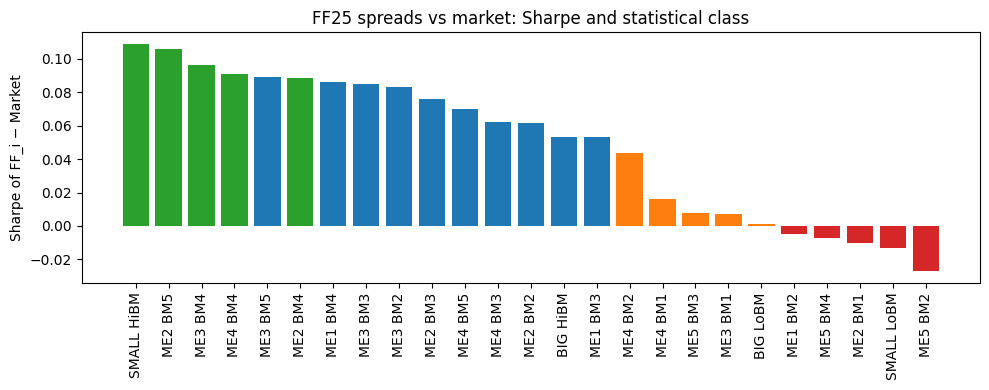

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df = spread_stats.copy()
df['class'] = np.select(
    [df['dsr_pass'], df['psr_pass'], df['sr_rel'] <= 0],
    ['DSR pass', 'PSR only', 'No edge'],
    default='Inconclusive',
)
df_sorted = df.sort_values('sr_rel', ascending=False)

plt.figure(figsize=(10, 4))
palette = {
    'DSR pass': 'tab:green',
    'PSR only': 'tab:blue',
    'Inconclusive': 'tab:orange',
    'No edge': 'tab:red',
}
colors = [palette.get(c, 'gray') for c in df_sorted['class']]
plt.bar(df_sorted.index, df_sorted['sr_rel'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Sharpe of FF_i − Market')
plt.title('FF25 spreads vs market: Sharpe and statistical class')
plt.tight_layout()
plt.show()


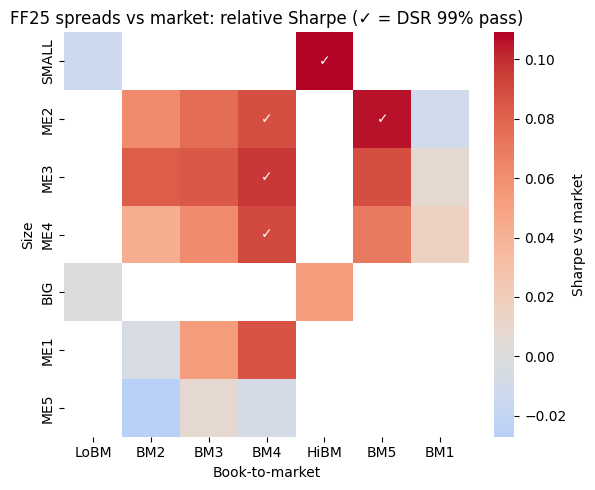

In [8]:
sr = spread_stats['sr_rel']
dsr_pass = spread_stats['dsr_pass']

size_labels = ['SMALL', 'ME2', 'ME3', 'ME4', 'BIG']
bm_labels = ['LoBM', 'BM2', 'BM3', 'BM4', 'HiBM']

sr_grid = pd.DataFrame(index=size_labels, columns=bm_labels, dtype=float)
mark_grid = pd.DataFrame(index=size_labels, columns=bm_labels, dtype=object)

for name, val in sr.items():
    size, bm = name.split()
    sr_grid.loc[size, bm] = val
    mark_grid.loc[size, bm] = '✓' if dsr_pass.loc[name] else ''

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    sr_grid.astype(float),
    annot=mark_grid,
    fmt='',
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Sharpe vs market'},
)
ax.set_xlabel('Book-to-market')
ax.set_ylabel('Size')
ax.set_title('FF25 spreads vs market: relative Sharpe (✓ = DSR 99% pass)')
plt.tight_layout()
plt.show()


- Only **SMALL HiBM** clears the deflated Sharpe bar at 99% confidence once we combine $K_{eff}$ from the spread correlations with the cross-spread Sharpe variance.
- Around **eleven** portfolios look attractive on a single-spread PSR basis at the same alpha but fall short after the multiple-testing adjustment.
- Many spreads have modest relative Sharpe, so MinTRL indicates that substantially more history would be required to make a 99% call on them.
- Overall, the small-value corner remains the only robust outperformer versus the market under this stricter DSR setup.

## oFDR + hybrid FWER–FDR filter on FF25 vs market

- Build the 25 FF size–BM spreads vs market excess returns.
- Estimate the effective trials $K_{eff}$ from the spread correlation matrix (participation ratio), then set the DSR null $SR_0$ using the False Strategy Theorem.
- For each spread: (i) compute DSR at 99% (FWER-ish); (ii) compute observed Bayesian FDR (oFDR) with a 10% prior on skill, deflating $SR_0$/$SR_1$ by $K_{eff}$.
- Flag spreads that either clear DSR or have oFDR ≤ 20% to see which factors remain credible.


In [9]:

import numpy as np
import pandas as pd
from pathlib import Path

import finance_data.spreads as sp
from finance_data import metrics

# Resolve data directory whether running from repo root or notebooks/
CANDIDATES = [Path.cwd() / 'data', Path.cwd().parent / 'data']
FF25_NAME = 'french25_excess_monthly.csv'
FACTOR_NAME = 'F-F_Research_Data_Factors_tbl0_192607_latest.csv'
DATA_DIR = None
for cand in CANDIDATES:
    ff25_path = cand / FF25_NAME
    factor_path = cand / 'famafrench_cache' / FACTOR_NAME
    if ff25_path.exists() and factor_path.exists():
        DATA_DIR = cand
        break

if DATA_DIR is None:
    raise FileNotFoundError(f"Could not find {FF25_NAME} and {FACTOR_NAME} in {CANDIDATES}")

FF25_FILE = DATA_DIR / FF25_NAME
FACTOR_FILE = DATA_DIR / 'famafrench_cache' / FACTOR_NAME

# Base settings for this screen
ALPHA = 0.05  # repo-wide confidence level
PRIOR_H1 = 0.10  # prior probability of skill used for oFDR

# Load FF25 excess returns (already in decimals) and market excess (in % -> decimals)
ff25 = pd.read_csv(FF25_FILE)
ff25['Date'] = pd.to_datetime(ff25['Date'])
ff25 = ff25.set_index('Date').sort_index()

factors = pd.read_csv(FACTOR_FILE)
factors['Date'] = pd.to_datetime(factors['Date'])
factors = factors.set_index('Date').sort_index()
mkt_excess = (factors['Mkt-RF'] / 100.0).rename('Mkt_RF_excess')

spreads = ff25.sub(mkt_excess, axis=0).dropna(how='all').dropna(axis=1, how='all')

# Basic stats and effective trials
stats = sp.summarize_spreads(spreads)

corr = spreads.corr().fillna(0.0)
eigvals = np.linalg.eigvalsh(corr.values)
if np.isfinite(eigvals).all() and eigvals.sum() > 1e-12:
    K_EFF = float((eigvals.sum() ** 2) / np.square(eigvals).sum())
else:
    K_EFF = float(spreads.shape[1])

# DSR null via False Strategy Theorem
dsr_null = sp._dsr_null_from_spreads(stats['sr_rel'], K_EFF)
sr0_dsr = dsr_null['sr0_dsr']

dsr_res = stats.apply(lambda row: sp.dsr_row(row, sr0_dsr=sr0_dsr, alpha=ALPHA), axis=1)
stats = stats.join(dsr_res)

# Observed Bayesian FDR (oFDR) with prior PRI0R_H1; m_eff deflates SR0/SR1
ofdr_rows = []
for name, series in spreads.items():
    res = metrics.observed_fdr(
        series,
        sr_benchmark=0.0,
        sr_alt=None,
        prior_h1=PRIOR_H1,
        m_eff=K_EFF,
    )
    res['portfolio'] = name
    ofdr_rows.append(res)

ofdr_df = pd.DataFrame(ofdr_rows).set_index('portfolio')
stats = stats.join(ofdr_df[['ofdr', 'p_value', 'sr0', 'sr1', 'sr_hat']])

# Quick flagging: DSR pass (FWER-ish @ALPHA) or oFDR <= 20%
stats['flag'] = np.select(
    [
        stats['dsr_pass'],
        stats['ofdr'] <= 0.20,
    ],
    [
        f'DSR pass (FWER-ish @{int(ALPHA*100)}%)',
        'Low oFDR (<=20%)',
    ],
    default='Not robust',
)

print(f"K={spreads.shape[1]} spreads; K_eff≈{K_EFF:.2f}; DSR SR0≈{sr0_dsr:.3f}; alpha={ALPHA}")
display_cols = ['sr_rel', 'dsr', 'ofdr', 'p_value', 'flag']
stats.sort_values(['dsr_pass', 'ofdr'], ascending=[False, True])[display_cols].head(12)


K=25 spreads; K_eff≈3.75; DSR SR0≈0.044; alpha=0.05


,sr_rel,dsr,ofdr,p_value,flag
portfolio,,,,,
SMALL HiBM,0.109110,0.993509,0.009359,0.000894,DSR pass (FWER-ish @5%)
ME2 BM5,0.106000,0.987941,0.023052,0.002223,DSR pass (FWER-ish @5%)
ME3 BM4,0.096355,0.972418,0.059724,0.005985,DSR pass (FWER-ish @5%)
ME2 BM4,0.088669,0.952596,0.104578,0.011015,DSR pass (FWER-ish @5%)
ME4 BM4,0.090924,0.954823,0.110250,0.011658,DSR pass (FWER-ish @5%)
ME1 BM4,0.086367,0.947810,0.109443,0.011606,Low oFDR (<=20%)
ME3 BM5,0.089002,0.949544,0.119946,0.012848,Low oFDR (<=20%)
ME3 BM3,0.084966,0.927276,0.191421,0.022262,Low oFDR (<=20%)
ME3 BM2,0.083270,0.915365,0.232665,0.028462,Not robust


### Pipeline: DSR/oFDR via zoo helpers

Re-run the FF25 vs market screen using the reusable pipeline helpers (DSR + oFDR grid). Baseline grid: alpha = {1%, 2.5%, 5%}, priors = {1%, 2%, 5%, 10%, 15%, 20%}, oFDR q = 20%.


In [10]:
from IPython.display import display
import numpy as np

from finance_data.pipeline.zoo import (
    TestConfig,
    global_screen,
    sensitivity_grid,
)

config_zoo = TestConfig(
    alpha_grid=(0.01, 0.025, 0.05),
    prior_grid=(0.01, 0.02, 0.05, 0.10, 0.15, 0.20),
    flag_rules=("union", "intersection", "dsr_only", "ofdr_only"),
    ofdr_q=0.20,
)

zoo_res = global_screen({"FF25_vs_mkt": spreads}, config_zoo)
ff25_zoo = zoo_res["families"]["FF25_vs_mkt"]
zoo_stats = ff25_zoo["stats"]
zoo_dsr = ff25_zoo["dsr"]
zoo_ofdr = ff25_zoo["ofdr"]
zoo_flags = ff25_zoo["flags"]
zoo_sens = sensitivity_grid(
    zoo_dsr,
    zoo_ofdr,
    alphas=config_zoo.alpha_grid,
    priors=config_zoo.prior_grid,
    q=config_zoo.ofdr_q,
)

alpha_base = 0.05
prior_base = 0.10
dsr_base = zoo_dsr.xs(alpha_base, level="alpha")
ofdr_base = zoo_ofdr.xs(prior_base, level="prior")

results_tbl = (
    zoo_stats.join(dsr_base[["dsr", "dsr_pass", "sr0_dsr"]])
    .join(ofdr_base[["ofdr", "p_value"]])
)
results_tbl["flag"] = np.select(
    [
        results_tbl["dsr_pass"],
        results_tbl["ofdr"] <= config_zoo.ofdr_q,
    ],
    [
        f"DSR pass (FWER-ish @{int(alpha_base*100)}%)",
        f"Low oFDR (<= {int(config_zoo.ofdr_q*100)}%)",
    ],
    default="Not robust",
)

print(
    f"K={spreads.shape[1]} spreads; K_eff≈{ff25_zoo['m_eff']:.2f}; "
    f"DSR SR0≈{dsr_base['sr0_dsr'].iloc[0]:.3f}; alpha grid={config_zoo.alpha_grid}; "
    f"prior grid={config_zoo.prior_grid}"
)

print("Top names at alpha=5%, prior=10%:")
display(results_tbl.sort_values(["dsr_pass", "ofdr"], ascending=[False, True]).head(12))

print("\nSensitivity grid (pipeline):")
display(zoo_sens["summary"])

print("\nFlag frequency (pipeline):")
display(zoo_sens["frequency"])

# Keep main tables for later cells if needed
zoo_results_tbl = results_tbl
zoo_sensitivity = zoo_sens


K=25 spreads; K_eff≈3.75; DSR SR0≈0.044; alpha grid=(0.01, 0.025, 0.05); prior grid=(0.01, 0.02, 0.05, 0.1, 0.15, 0.2)
Top names at alpha=5%, prior=10%:


,n_obs,mu_d,sigma_d,sr_rel,skew,kurt,dsr,dsr_pass,sr0_dsr,ofdr,p_value,flag
portfolio,,,,,,,,,,,,
SMALL HiBM,1191,0.006478,0.059372,0.109110,4.643733,49.290756,0.993509,True,0.043957,0.009359,0.000894,DSR pass (FWER-ish @5%)
ME2 BM5,1191,0.005360,0.050569,0.106000,2.492723,23.692390,0.987941,True,0.043957,0.023052,0.002223,DSR pass (FWER-ish @5%)
ME3 BM4,1191,0.003061,0.031768,0.096355,2.873667,33.211157,0.972418,True,0.043957,0.059724,0.005985,DSR pass (FWER-ish @5%)
ME2 BM4,1191,0.003407,0.038425,0.088669,3.913145,53.072348,0.952596,True,0.043957,0.104578,0.011015,DSR pass (FWER-ish @5%)
ME4 BM4,1191,0.002737,0.030101,0.090924,2.196633,27.069970,0.954823,True,0.043957,0.110250,0.011658,DSR pass (FWER-ish @5%)
ME1 BM4,1191,0.004337,0.050215,0.086367,5.071029,73.777916,0.947810,False,0.043957,0.109443,0.011606,Low oFDR (<= 20%)
ME3 BM5,1191,0.004135,0.046462,0.089002,2.620564,28.259815,0.949544,False,0.043957,0.119946,0.012848,Low oFDR (<= 20%)
ME3 BM3,1191,0.002201,0.025908,0.084966,1.392609,13.972013,0.927276,False,0.043957,0.191421,0.022262,Low oFDR (<= 20%)
ME3 BM2,1191,0.002090,0.025099,0.083270,0.653046,7.007019,0.915365,False,0.043957,0.232665,0.028462,Not robust



Sensitivity grid (pipeline):


,alpha,prior_h1,dsr_pass_cnt,low_ofdr_cnt,flagged_total,top_flags
0,0.010000,0.010000,1,1,1,SMALL HiBM
1,0.010000,0.020000,1,2,2,"ME2 BM5, SMALL HiBM"
2,0.010000,0.050000,1,4,4,"ME2 BM4, ME2 BM5, ME3 BM4"
3,0.010000,0.100000,1,8,8,"ME1 BM4, ME2 BM4, ME2 BM5"
4,0.010000,0.150000,1,10,10,"ME1 BM4, ME2 BM3, ME2 BM4"
5,0.010000,0.200000,1,10,10,"ME1 BM4, ME2 BM3, ME2 BM4"
6,0.025000,0.010000,2,1,2,"ME2 BM5, SMALL HiBM"
7,0.025000,0.020000,2,2,2,"ME2 BM5, SMALL HiBM"
8,0.025000,0.050000,2,4,4,"ME2 BM4, ME2 BM5, ME3 BM4"
9,0.025000,0.100000,2,8,8,"ME1 BM4, ME2 BM4, ME2 BM5"



Flag frequency (pipeline):


,hits
SMALL HiBM,18
ME2 BM5,17
ME3 BM4,14
ME2 BM4,14
ME4 BM4,12
ME1 BM4,9
ME3 BM3,9
ME3 BM5,9
ME2 BM3,6
ME3 BM2,6


### Tier 1 zoo using the data fetcher (mandatory factors + main families)

Fetch the mandatory factor panel (FF3/FF5 + momentum) and the Tier 1 strategy families (FF 5x5 size–BM, size deciles, 49 industries). Run the same DSR/oFDR screen on each family and on the combined Tier 1 pool. This uses the Fama French data loader (monthly, excess returns only; no daily/100x100/alt industries).


In [11]:
from finance_data.french import (
    load_us_industries_49,
    load_us_momentum_factor,
    load_us_size_bm_25,
    load_us_size_deciles,
    pivot_family,
)
from finance_data.pipeline.zoo import (
    MonthlyPanel,
    build_factor_panel,
    align_excess_returns,
)

# Mandatory factors (FF5 + momentum) and RF
factor_panel = build_factor_panel(include_momentum=True)

# Tier 1 families (monthly, excess returns from Ken French)
sizebm_long = load_us_size_bm_25(rf=factor_panel.rf)
size10_long = load_us_size_deciles(rf=factor_panel.rf)
ind49_long = load_us_industries_49()
mom_long = load_us_momentum_factor()

sizebm_wide = pivot_family(sizebm_long, ["US_size_BM_25"])
size10_wide = pivot_family(size10_long, ["US_size_10"])
ind49_wide = pivot_family(ind49_long, ["US_industries_49"])

# Align to factor dates; returns are already excess, so no RF subtraction
families_raw = {
    "US_size_BM_25": sizebm_wide,
    "US_size_10": size10_wide,
    "US_industries_49": ind49_wide,
}
families_aligned = {}
coverage = {}
for name, df in families_raw.items():
    panel = MonthlyPanel(data=df, name=name, tier="Tier1")
    aligned, cov = align_excess_returns(panel, factor_panel, subtract_rf=False)
    families_aligned[name] = aligned
    coverage[name] = cov

# Run screens per family and combined
tier1_res = global_screen(families_aligned, config_zoo)
tier1_stats = {k: v["stats"] for k, v in tier1_res["families"].items()}
tier1_flags = {k: v["flags"] for k, v in tier1_res["families"].items()}
tier1_m_eff = {k: v["m_eff"] for k, v in tier1_res["families"].items()}

print("Tier 1 coverage (aligned to factors):")
display(pd.DataFrame(coverage).T)

print("\nTier 1 per-family K_eff and flagged counts (union rule):")
rows = []
for name, flags in tier1_flags.items():
    rows.append({
        "family": name,
        "K_eff": tier1_m_eff.get(name, np.nan),
        "flagged_union": int(flags["union"].sum()) if not flags.empty else 0,
    })
display(pd.DataFrame(rows).set_index("family"))

print("\nCombined Tier 1 pool (stacked) — top names @alpha=5%, prior=10%:")
tier1_global = tier1_res["global"]
g_dsr = tier1_global["dsr"].xs(alpha_base, level="alpha")
g_ofdr = tier1_global["ofdr"].xs(prior_base, level="prior")
g_stats = tier1_global["stats"]
g_tbl = (
    g_stats.join(g_dsr[["dsr", "dsr_pass", "sr0_dsr"]])
    .join(g_ofdr[["ofdr", "p_value"]])
    .sort_values(["dsr_pass", "ofdr"], ascending=[False, True])
).head(15)
display(g_tbl)


Tier 1 coverage (aligned to factors):


,start,end,n_obs,n_assets,missing_share,family,tier
US_size_BM_25,2020-12-31 00:00:00,2025-10-31 00:00:00,59,25,0.000000,US_size_BM_25,Tier1
US_size_10,2020-12-31 00:00:00,2025-10-31 00:00:00,59,10,0.000000,US_size_10,Tier1
US_industries_49,2020-12-31 00:00:00,2025-09-30 00:00:00,58,49,0.000000,US_industries_49,Tier1



Tier 1 per-family K_eff and flagged counts (union rule):


,K_eff,flagged_union
family,,
US_size_BM_25,1.592204,2
US_size_10,1.253548,1
US_industries_49,3.245247,1



Combined Tier 1 pool (stacked) — top names @alpha=5%, prior=10%:


,n_obs,mu_d,sigma_d,sr_rel,skew,kurt,dsr,dsr_pass,sr0_dsr,ofdr,p_value
portfolio,,,,,,,,,,,
US_industries_49::Coal,58,0.041769,0.127170,0.328449,0.419459,2.991079,0.978475,True,0.066206,0.265388,0.030250
US_size_BM_25::BIG_HiBM,59,0.018863,0.062821,0.300265,-0.036593,2.188327,0.963633,True,0.066206,0.394196,0.054287
US_industries_49::Chips,58,0.021103,0.070650,0.298706,-0.264532,2.647201,0.960268,True,0.066206,0.431072,0.062990
US_industries_49::Smoke,58,0.015857,0.057606,0.275265,-0.069341,3.021532,0.943716,False,0.066206,0.499127,0.082984
US_industries_49::Hardw,58,0.016200,0.059877,0.270555,-0.441437,2.544506,0.937333,False,0.066206,0.539303,0.097175
US_industries_49::Oil,58,0.019586,0.077664,0.252191,0.438055,4.355130,0.924314,False,0.066206,0.546755,0.100865
US_industries_49::Cnstr,58,0.020790,0.079954,0.260019,-0.105686,2.275452,0.929202,False,0.066206,0.549722,0.101779
US_industries_49::Other,58,0.012029,0.046804,0.257013,-0.271665,2.756946,0.924908,False,0.066206,0.571374,0.110829
US_size_10::SIZE_10,59,0.011205,0.043986,0.254742,-0.587342,2.848738,0.922113,False,0.066206,0.590325,0.119400



### Sensitivity: priors and alpha

Check how conclusions move when we change the oFDR skill prior (5%, 10%, 20%) and the DSR confidence level (α = 5% vs 1%).

In [12]:

# Helper to rerun the screen for different (alpha, prior_h1)
def run_screen(alpha: float, prior_h1: float):
    stats_local = sp.summarize_spreads(spreads)
    dsr_null_local = sp._dsr_null_from_spreads(stats_local['sr_rel'], K_EFF)
    sr0_dsr_local = dsr_null_local['sr0_dsr']

    dsr_local = stats_local.apply(
        lambda row: sp.dsr_row(row, sr0_dsr=sr0_dsr_local, alpha=alpha), axis=1
    )
    stats_local = stats_local.join(dsr_local)

    ofdr_rows_local = []
    for name, series in spreads.items():
        res = metrics.observed_fdr(
            series,
            sr_benchmark=0.0,
            sr_alt=None,
            prior_h1=prior_h1,
            m_eff=K_EFF,
        )
        res['portfolio'] = name
        ofdr_rows_local.append(res)
    ofdr_local = pd.DataFrame(ofdr_rows_local).set_index('portfolio')
    stats_local = stats_local.join(ofdr_local[['ofdr', 'p_value']])

    flagged = stats_local.loc[(stats_local['dsr_pass']) | (stats_local['ofdr'] <= 0.20)].copy()
    flagged['alpha'] = alpha
    flagged['prior_h1'] = prior_h1
    return stats_local, flagged

alpha_grid = [0.05, 0.01]
prior_grid = [0.05, 0.10, 0.20]

summary_rows = []
for alpha in alpha_grid:
    for prior in prior_grid:
        _, flagged = run_screen(alpha, prior)
        top = flagged.sort_values(['dsr_pass', 'ofdr'], ascending=[False, True]).index[:3]
        summary_rows.append(
            {
                'alpha': alpha,
                'prior_h1': prior,
                'dsr_pass_cnt': int(flagged['dsr_pass'].sum()),
                'low_ofdr_cnt': int((flagged['ofdr'] <= 0.20).sum()),
                'flagged_total': int(flagged.shape[0]),
                'top_flags': ', '.join(top),
            }
        )

summary_df = pd.DataFrame(summary_rows).sort_values(['alpha', 'prior_h1'])
summary_df


,alpha,prior_h1,dsr_pass_cnt,low_ofdr_cnt,flagged_total,top_flags
3,0.010000,0.050000,1,4,4,"SMALL HiBM, ME2 BM5, ME3 BM4"
4,0.010000,0.100000,1,8,8,"SMALL HiBM, ME2 BM5, ME3 BM4"
5,0.010000,0.200000,1,10,10,"SMALL HiBM, ME2 BM5, ME3 BM4"
0,0.050000,0.050000,5,4,5,"SMALL HiBM, ME2 BM5, ME3 BM4"
1,0.050000,0.100000,5,8,8,"SMALL HiBM, ME2 BM5, ME3 BM4"
2,0.050000,0.200000,5,10,10,"SMALL HiBM, ME2 BM5, ME3 BM4"



### Stability: rolling survival (Sharpe > 0)

Use 10-year rolling windows (step = 1 year) to see how often the most credible spreads maintain positive Sharpe vs the market.

In [13]:
from finance_data import survival

# Focus on the most credible names at the base settings
base_stats, base_flagged = run_screen(alpha=ALPHA, prior_h1=PRIOR_H1)
focus = base_flagged.sort_values(['dsr_pass', 'ofdr'], ascending=[False, True]).index.tolist()[:6]

sr_mat, survival_mat, meta = survival.compute_survival_map(
    spreads[focus], window=120, step=12
)

sr_df = pd.DataFrame(sr_mat, index=focus)
surv_df = pd.DataFrame(survival_mat, index=focus)

survival_rate = surv_df.mean(axis=1)
rolling_sr_mean = sr_df.mean(axis=1)

stability_summary = (
    pd.DataFrame(
        {
            'survival_rate': survival_rate,
            'avg_rolling_sr': rolling_sr_mean,
        }
    )
    .sort_values(['survival_rate', 'avg_rolling_sr'], ascending=False)
)

stability_summary

,survival_rate,avg_rolling_sr
ME3 BM4,0.911111,0.139421
SMALL HiBM,0.911111,0.133724
ME2 BM5,0.888889,0.138298
ME2 BM4,0.833333,0.121377
ME1 BM4,0.811111,0.109354
ME4 BM4,0.800000,0.108773


## Factor benchmarking vs FF3/FF5
Check whether the strongest spreads still deliver positive alpha after controlling for standard Fama-French factors (3- and 5-factor models).

In [14]:
import statsmodels.api as sm
from finance_data.datasets import KenFrenchLoader

loader = KenFrenchLoader(cache_dir=DATA_DIR / 'famafrench_cache')
ff5_raw = loader.load_table("F-F_Research_Data_5_Factors_2x3", table=0, start_date=START)
ff5 = (ff5_raw / 100.0).rename(columns=lambda c: c.replace('-', '_'))
ff5.index = pd.to_datetime(ff5.index).to_period('M').to_timestamp('M')
ff5 = ff5.loc[ff25.index.min(): ff25.index.max()]

ff3 = ff5[["Mkt_RF", "SMB", "HML"]]
ff5_factors = ff5[["Mkt_RF", "SMB", "HML", "RMW", "CMA"]]


def factor_alpha(series: pd.Series, factors: pd.DataFrame):
    aligned = pd.concat([series.rename("excess"), factors], axis=1, join="inner").dropna()
    if aligned.shape[0] < factors.shape[1] + 2:
        return None
    y = aligned["excess"]
    X = sm.add_constant(aligned.drop(columns="excess"))
    res = sm.OLS(y, X).fit()
    alpha_m = res.params["const"]
    ann_alpha = (1.0 + alpha_m) ** 12 - 1.0
    return {
        "alpha_m": alpha_m,
        "alpha_ann": ann_alpha,
        "t_alpha": res.tvalues["const"],
        "r2": res.rsquared,
        "n_obs": int(res.nobs),
    }


alpha_rows = []
for name in focus:
    series = ff25[name]
    res3 = factor_alpha(series, ff3)
    res5 = factor_alpha(series, ff5_factors)
    row = {"portfolio": name}
    if res3:
        row.update(
            {
                "alpha3_m": res3["alpha_m"],
                "alpha3_ann": res3["alpha_ann"],
                "t_alpha3": res3["t_alpha"],
                "r2_ff3": res3["r2"],
                "n_obs": res3["n_obs"],
            }
        )
    if res5:
        row.update(
            {
                "alpha5_m": res5["alpha_m"],
                "alpha5_ann": res5["alpha_ann"],
                "t_alpha5": res5["t_alpha"],
                "r2_ff5": res5["r2"],
            }
        )
    alpha_rows.append(row)

alpha_table = (
    pd.DataFrame(alpha_rows)
    .set_index("portfolio")
    .sort_values("alpha5_ann", ascending=False)
)
alpha_table

,alpha3_m,alpha3_ann,t_alpha3,r2_ff3,n_obs,alpha5_m,alpha5_ann,t_alpha5,r2_ff5
portfolio,,,,,,,,,
ME1 BM4,0.001386,0.016755,2.878759,0.951411,747,0.001524,0.018444,3.105932,0.951886
SMALL HiBM,0.001960,0.023779,2.682913,0.902847,747,0.001509,0.018263,2.051272,0.906135
ME4 BM4,0.000589,0.007091,0.925571,0.886041,747,0.000351,0.004220,0.540193,0.886858
ME2 BM4,0.000599,0.007216,1.298220,0.947308,747,0.000236,0.002838,0.505830,0.948657
ME3 BM4,0.000315,0.003788,0.586965,0.922011,747,-0.000181,-0.002170,-0.335377,0.924938
ME2 BM5,-0.000020,-0.000241,-0.040055,0.953724,747,-0.000224,-0.002685,-0.437256,0.953948


## Train/test split stability
How well do the top names hold up out-of-sample? Split the sample in half and compare in-sample vs out-of-sample Sharpe and PSR.

In [15]:
import numpy as np

mid = spreads.shape[0] // 2
spreads_first = spreads.iloc[:mid]
spreads_second = spreads.iloc[mid:]

def sharpe_psr(df: pd.DataFrame):
    sr_vals = df.apply(metrics.sharpe_ratio)
    psr_vals = df.apply(lambda s: metrics.probabilistic_sharpe_ratio(s, sr_benchmark=0.0)[0])
    return sr_vals, psr_vals

sr_first, psr_first = sharpe_psr(spreads_first[focus])
sr_second, psr_second = sharpe_psr(spreads_second[focus])

split_summary = pd.DataFrame(
    {
        "sr_first": sr_first,
        "sr_second": sr_second,
        "psr_second": psr_second,
        "sign_consistent": np.sign(sr_first) * np.sign(sr_second) > 0,
        "sr_change": sr_second - sr_first,
    }
).sort_values("sr_second", ascending=False)

split_summary

,sr_first,sr_second,psr_second,sign_consistent,sr_change
SMALL HiBM,0.116753,0.108401,0.995932,True,-0.008352
ME2 BM4,0.094230,0.086036,0.982154,True,-0.008193
ME1 BM4,0.092058,0.085780,0.981877,True,-0.006279
ME2 BM5,0.125313,0.082973,0.978598,True,-0.042340
ME3 BM4,0.115745,0.072692,0.962022,True,-0.043052
ME4 BM4,0.114102,0.061514,0.933418,True,-0.052588


## Block bootstrap robustness for DSR
Block-bootstrap each spread (12-month blocks) to see how often DSR would still pass after accounting for sampling noise and autocorrelation.

In [16]:
from scipy.stats import norm


def block_bootstrap(series: pd.Series, n_boot: int = 400, block: int = 12, seed: int = 123):
    arr = series.dropna().values
    T = len(arr)
    if T == 0:
        return []
    block = min(block, T)
    blocks = [arr[i : i + block] for i in range(0, T - block + 1)]
    rng = np.random.default_rng(seed)
    draws_per_sample = int(np.ceil(T / block))
    samples = []
    for _ in range(n_boot):
        idx = rng.integers(0, len(blocks), size=draws_per_sample)
        sample = np.concatenate([blocks[i] for i in idx])[:T]
        samples.append(sample)
    return samples


boot_rows = []
for i, name in enumerate(focus):
    series = spreads[name].dropna()
    samples = block_bootstrap(series, n_boot=400, block=12, seed=123 + i)
    if not samples:
        continue
    sr_boot = []
    dsr_passes = 0
    for sample in samples:
        s = pd.Series(sample)
        sr_hat = metrics.sharpe_ratio(s)
        sr_boot.append(sr_hat)
        skew = metrics.sample_skewness(s)
        kurt = metrics.sample_kurtosis(s)
        sigma = metrics._sigma_sr(sr0_dsr, skew, kurt, len(s))
        if np.isfinite(sigma) and sigma > 0:
            dsr = norm.cdf((sr_hat - sr0_dsr) / sigma)
            dsr_passes += int(dsr >= 1.0 - ALPHA)
    boot_rows.append(
        {
            "portfolio": name,
            "dsr_pass_rate": dsr_passes / len(samples),
            "sr_boot_mean": float(np.mean(sr_boot)),
            "sr_boot_std": float(np.std(sr_boot)),
        }
    )

boot_dsr = (
    pd.DataFrame(boot_rows)
    .set_index("portfolio")
    .sort_values("dsr_pass_rate", ascending=False)
)
boot_dsr

,dsr_pass_rate,sr_boot_mean,sr_boot_std
portfolio,,,
SMALL HiBM,0.795000,0.108320,0.025764
ME2 BM5,0.732500,0.104837,0.027665
ME3 BM4,0.610000,0.098041,0.029569
ME2 BM4,0.597500,0.093989,0.028821
ME4 BM4,0.552500,0.093262,0.031098
ME1 BM4,0.495000,0.088954,0.027335


## Wider prior/alpha sensitivity
Stress-test the oFDR + DSR screen across a broader grid of priors and significance levels to see which names keep reappearing.

In [17]:
alpha_grid_ext = [0.01, 0.025, 0.05]
prior_grid_ext = [0.01, 0.02, 0.05, 0.10, 0.15, 0.20]

summary_ext_rows = []
freq_counter = {}

for alpha in alpha_grid_ext:
    for prior in prior_grid_ext:
        stats_local, flagged = run_screen(alpha, prior)
        flagged_names = flagged.index.tolist()
        for name in flagged_names:
            freq_counter[name] = freq_counter.get(name, 0) + 1
        top = flagged.sort_values(["dsr_pass", "ofdr"], ascending=[False, True]).index[:3]
        summary_ext_rows.append(
            {
                "alpha": alpha,
                "prior_h1": prior,
                "dsr_pass_cnt": int(flagged["dsr_pass"].sum()),
                "low_ofdr_cnt": int((flagged["ofdr"] <= 0.20).sum()),
                "flagged_total": int(flagged.shape[0]),
                "top_flags": ", ".join(top),
            }
        )

summary_ext = pd.DataFrame(summary_ext_rows).sort_values(["alpha", "prior_h1"])
flag_freq = pd.DataFrame({"hits": pd.Series(freq_counter)}).sort_values("hits", ascending=False)

from IPython.display import display
print("Sensitivity grid (alpha, prior_H1) with flagged counts and top names:")
display(summary_ext)
print()  # blank line
print("Flag frequency across sensitivity grid:")
display(flag_freq)


Sensitivity grid (alpha, prior_H1) with flagged counts and top names:


,alpha,prior_h1,dsr_pass_cnt,low_ofdr_cnt,flagged_total,top_flags
0,0.010000,0.010000,1,1,1,SMALL HiBM
1,0.010000,0.020000,1,2,2,"SMALL HiBM, ME2 BM5"
2,0.010000,0.050000,1,4,4,"SMALL HiBM, ME2 BM5, ME3 BM4"
3,0.010000,0.100000,1,8,8,"SMALL HiBM, ME2 BM5, ME3 BM4"
4,0.010000,0.150000,1,10,10,"SMALL HiBM, ME2 BM5, ME3 BM4"
5,0.010000,0.200000,1,10,10,"SMALL HiBM, ME2 BM5, ME3 BM4"
6,0.025000,0.010000,2,1,2,"SMALL HiBM, ME2 BM5"
7,0.025000,0.020000,2,2,2,"SMALL HiBM, ME2 BM5"
8,0.025000,0.050000,2,4,4,"SMALL HiBM, ME2 BM5, ME3 BM4"
9,0.025000,0.100000,2,8,8,"SMALL HiBM, ME2 BM5, ME3 BM4"



Flag frequency across sensitivity grid:


,hits
SMALL HiBM,18
ME2 BM5,17
ME3 BM4,14
ME2 BM4,14
ME4 BM4,12
ME3 BM5,9
ME1 BM4,9
ME3 BM3,9
ME3 BM2,6
ME2 BM3,6


## Economic magnitudes
Translate the spreads into annualized returns/Sharpe and pair with FF3/FF5 annualized alphas for the focus names.

In [18]:

econ = stats.loc[focus, ["mu_d", "sr_rel"]].copy()
econ["ann_spread"] = (1.0 + econ["mu_d"]) ** 12 - 1.0
# Annualized SR using sqrt(12) since stats are monthly
import numpy as np


econ["ann_sharpe"] = econ["sr_rel"] * np.sqrt(12)
econ = econ[["ann_spread", "ann_sharpe", "mu_d", "sr_rel"]].sort_values(
    "ann_spread", ascending=False
)

alpha_view = alpha_table[["alpha3_ann", "t_alpha3", "alpha5_ann", "t_alpha5"]].sort_values(
    "alpha5_ann", ascending=False
)

from IPython.display import display
print("Annualized economics of focus spreads (returns/Sharpe):")
display(econ)
print()  # blank line
print("FF3/FF5 annualized alphas and t-stats:")
display(alpha_view)


Annualized economics of focus spreads (returns/Sharpe):


,ann_spread,ann_sharpe,mu_d,sr_rel
portfolio,,,,
SMALL HiBM,0.080567,0.377970,0.006478,0.109110
ME2 BM5,0.066254,0.367195,0.005360,0.106000
ME1 BM4,0.053303,0.299185,0.004337,0.086367
ME2 BM4,0.041660,0.307157,0.003407,0.088669
ME3 BM4,0.037356,0.333782,0.003061,0.096355
ME4 BM4,0.033342,0.314971,0.002737,0.090924



FF3/FF5 annualized alphas and t-stats:


,alpha3_ann,t_alpha3,alpha5_ann,t_alpha5
portfolio,,,,
ME1 BM4,0.016755,2.878759,0.018444,3.105932
SMALL HiBM,0.023779,2.682913,0.018263,2.051272
ME4 BM4,0.007091,0.925571,0.004220,0.540193
ME2 BM4,0.007216,1.298220,0.002838,0.505830
ME3 BM4,0.003788,0.586965,-0.002170,-0.335377
ME2 BM5,-0.000241,-0.040055,-0.002685,-0.437256
